# Embedding to non-euclidean spaces with MAP

MAP (Manifold Approximation and Projection) is a lighter version of [UMAP]() with fewer assumptions. It simply performs the graph layout by optimizing the cross-entropy between a similarity graph and an initialized lower-dimensional embedding. The graph construction is conveniently done by TopOMetry with a loose manifold hypothesis only, and a spectral initialization is used.

For the purpose of data visualization, data is usually embedded to a 2D euclidean plane. However, several new studies (particularly involving single-cell data) have pointed to the utility of performing non-euclidean embeddings[1]()[2]()[3](). Here, we show how to perform these embeddings within TopOMetry. Please note this heavily relies on previous work on UMAP.

The key idea is we can embed data to any given space, such as spheres, hyperboloids and so on.


Let's begin installing some basic packages

In [1]:
# Installing some basic packages
#!pip install scanpy pymde umap-learn hnswlib nmslib kneed

In [2]:
# Installing TopOMetry
#!pip install -i https://test.pypi.org/simple/ topometry==0.0.2.7

To start we’ll load the usual selection of libraries.

In [3]:
import scanpy as sc
import topo as tp
%matplotlib inline

As a test dataset we’ll use 3k PBMCs from a Healthy Donor from 10X Genomics available in Scanpy and [here.](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

In [4]:
adata = sc.datasets.pbmc3k_processed()

After loading the data and QC, instead using PCA for linear dimensional reduction, we can use the TopOGraph to make a diffusion-based dimensional reduction to get the topological metrics that we gonna use on the graphs. 

In [5]:
# Start up the TopOGraph
tg = tp.TopOGraph(n_jobs=12, 
                         verbosity=1,
                         backend='hnwslib',
                         plot_spectrum=True)
tg.fit(adata.X)
db_diff_graph = tg.transform()

# Minimize divergence between the diffusion basis and diffusion graph
emb_db_diff_map = tg.MAP() # by default computes a spectral initialisation

Computing neighborhood graph...
 Base kNN graph computed in 0.869914 (sec)
Building topological basis...using diffusion model.
 Topological basis fitted with multiscale self-adaptive diffusion maps in 10.757578 (sec)
    Building topological graph...
     Topological `diff` graph extracted in = 0.267637 (sec)
         Spectral layout not stored at TopOGraph.SpecLayout. Trying to compute...
         Optimized MAP embedding in = 28.920412 (sec)


Now we need to find the clusters. Here we clustering with leiden

In [6]:
sc.tl.leiden(adata, adjacency=db_diff_graph)

In [7]:
labels = adata.obs['leiden'].astype('int')

# Default 2D euclidean plane 

This is the standard ploting option for printed material such as manuscripts and research articles. TopOMetry has a plotting module that can be used to visualize this data:

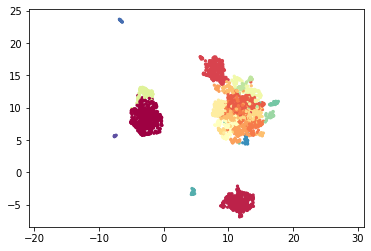

In [8]:
tp.pl.scatter(emb_db_diff_map, labels=labels)

Alternatively, you might want to add TopOMetry representations to the AnnData object in which scanpy stores the high-dimensional single-cell gene expression matrices, metadata dataframes and lower-dimensional representations.
The AnnData object stores lower-dimensional representations at the `.obsm['X_representation_name']` slot.

In [9]:
adata.obsm['X_db'] = tg.MSDiffMap
adata.obsm['X_db_diff_MAP'] = emb_db_diff_map # or tg.db_diff_MAP, as TopOGraph stores it

These representations can be used in scanpy functions where the parameters `use_rep` or `basis` are present, such as for neighborhood density estimation and plotting.

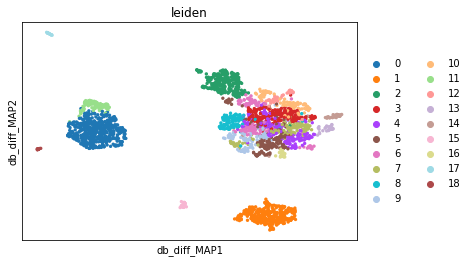

In [10]:
sc.pl.embedding(adata, basis='db_diff_MAP', color='leiden')

TopOMetry can also plot data onto 3 dimensions. When using the 'TkAgg' matplotlib backend users can interactively explore them. For this, we'll need to compute a new initialisation, with 3 dimensions.

         Optimized MAP embedding in = 30.589260 (sec)


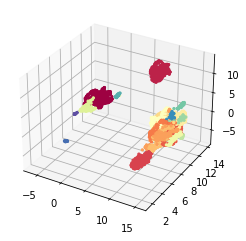

In [11]:
# compute new initialisation
init = tg.spectral_layout(n_components=3)

# optimize layout
db_diff_emb3d = tg.MAP(n_components=3, init=init)

# plot
tp.pl.scatter3d(db_diff_emb3d, labels=labels)

# Spherical embeddings


Here we project the lower dimensional embedding into a spheric space. 

         Optimized MAP embedding in = 28.121897 (sec)


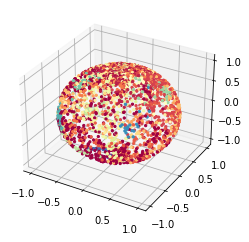

In [12]:
db_diff_sphere = tg.MAP(output_metric='haversine')
tp.pl.sphere(db_diff_sphere, labels=labels)

# Torus embedding

TopOMetry allows you to vizualize your data as a donut, using for this the torus embedding. Torus is a surface of revolution generated by revolving a circle in three-dimensional space about an axis. See more details [here](https://en.wikipedia.org/wiki/Torus)

         Optimized MAP embedding in = 29.415342 (sec)


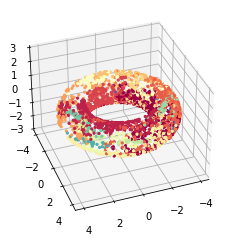

In [13]:
db_diff_map_torus = tg.MAP(n_components=2, output_metric='torus')
tp.pl.toroid(db_diff_map_torus, labels=labels)

# Hyperboloid embedding


On data science, it is common to use hyperbolic representations for hierarchical data (see more context [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6534139/)). We can use the [hyperboloid model](https://en.wikipedia.org/wiki/Hyperboloid_model) on TopOMetry to see our data in this space:

         Optimized MAP embedding in = 30.903521 (sec)


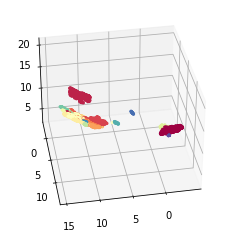

In [14]:
db_diff_map_hyper = tg.MAP(output_metric='hyperboloid')
tp.pl.hyperboloid(db_diff_map_hyper, labels=labels)

Usually, we use [Poincare’s disk model](https://en.wikipedia.org/wiki/Poincar%C3%A9_disk_model) for this visualization of a hyperbolic space.

         Optimized MAP embedding in = 33.370153 (sec)


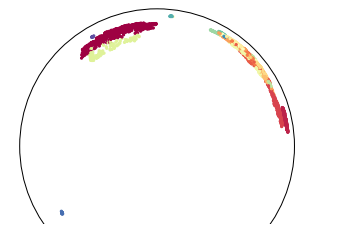

In [15]:
init = tg.spectral_layout(n_components=2)
db_diff_map_poinc = tg.MAP(n_components=2, init=init, output_metric='poincare')
tp.pl.poincare(db_diff_map_poinc, labels=labels)

# Gaussian-Energy Embedding

Unlike most approaches that represent nodes as point vectors in a low-dimensional continuous space, each one with exact values for every parameter, we can embed each node as a Gaussian distribution and infers a probability distribution over all possible values, allowing us to capture uncertainty about the representation. See more context [here](https://doi.org/10.1371/journal.pcbi.1008186) and [here](https://arxiv.org/abs/1707.03815v4)

In [18]:
init = tg.spectral_layout(n_components=5)
db_dmap_gauss = tg.MAP(output_metric='gaussian_energy', init=init, n_components=5)
tp.pl.gaussian_potential(db_dmap_gauss, labels=labels)

         Optimized MAP embedding in = 36.296349 (sec)


/home/davi/.local/lib/python3.9/site-packages/topo/plot.py:149: RuntimeWarning: invalid value encountered in sqrt
  width, height = np.sqrt(width + 1), np.sqrt(height + 1)


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

### That was it for this tutorial!

Let me know if you have any questions. Feel free to [open an issue](https://github.com/davisidarta/topometry/issues) or to contact me via davisidarta@fcm.unicamp.br.